In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torchvision import datasets, transforms
import yaml
import shutil
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np
from torch.autograd import Variable
from functools import reduce
import operator
import copy
%matplotlib inline

In [42]:
# load the configuration
with open('config/config_cnn.yaml', 'r') as f:
    config = yaml.safe_load(f)

# get the configuration parameters
conv_layers = config['model']['conv_layers']
filter_size = config['model']['filter_size']
stride = config['model']['stride']
padding = config['model']['padding']
pool_type = config['model']['pool_type']
pool_size = config['model']['pool_size']
pool_stride = config['model']['pool_stride']
hidden_layers = config['model']['hidden_layers']
activation_function = config['model']['activation_function']
use_batch_norm = config['model']['use_batch_norm']
dropout_rate = config['model']['dropout_rate']
regularization = config['model']['regularization']
l1_lambda = config['model']['l1_lambda']
l2_lambda = config['model']['l2_lambda']
optimizer_type = config['optimizer']['type']
learning_rate = config['optimizer']['learning_rate']
lr_scheduler = config['optimizer']['lr_scheduler']
step_size = config['optimizer']['step_size']
gamma = config['optimizer']['gamma']
input_size = config['model']['input_size']
output_size = config['model']['output_size']
batch_size = config['batch_size']


# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 128

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.EMNIST(root='./data',split='balanced', train=True,
                                   download=True, transform=transform)
test_data = datasets.EMNIST(root='./data',split='balanced', train=False,
                                  download=True, transform=transform)
print("the number of train data samples: ", len(train_data))
print("the number of test data samples: ", len(test_data))

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

the number of train data samples:  112800
the number of test data samples:  18800


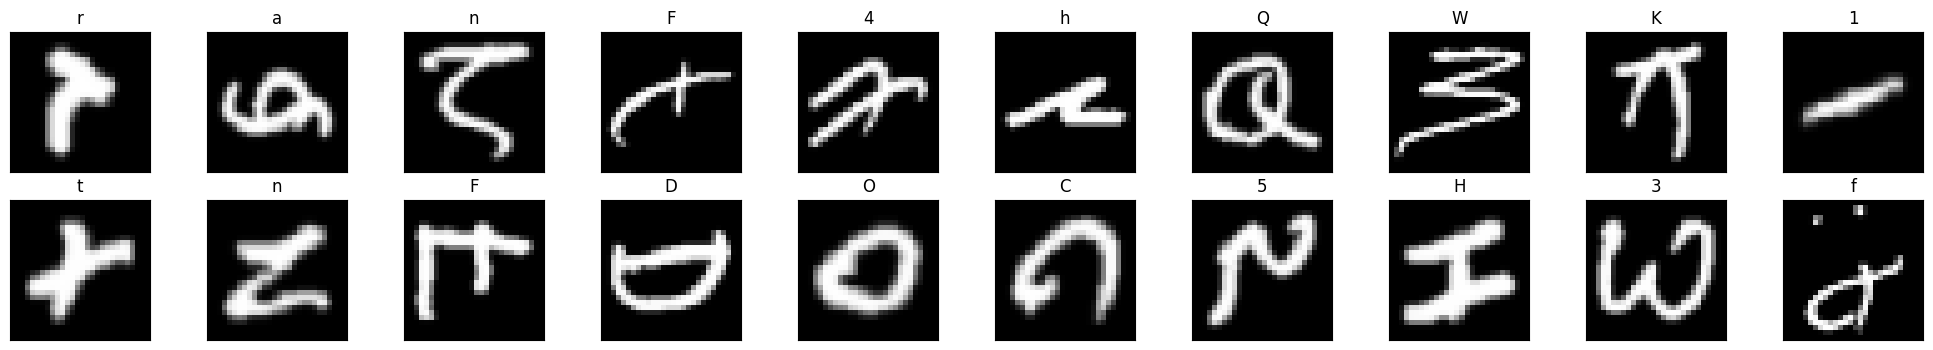

In [43]:
# obtain one batch of training images
dataiter = iter(train_loader)

images, labels = dataiter.__next__()
images = images.numpy()

 # emnist-balanced-mapping.txt 
with open('data/EMNIST/processed/emnist-balanced-mapping.txt') as f: 
    lines = f.readlines()
    
label_dict = {}
for row in lines:
    list1 = row.split(' ')
    label_dict[int(list1[0])] = chr(int(list1[1]))   #索引值 (list1[0])  对应 ASCII code (list1[1])

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(label_dict.get(labels[idx].item())))

In [44]:
img = np.squeeze(images[0])
width, height = img.shape
print(width, height)


28 28


In [45]:
# define the activation function
if activation_function == 'ReLU':
    activation = nn.ReLU()
elif activation_function == 'LeakyReLU':
    activation = nn.LeakyReLU()
elif activation_function == 'ELU':
    activation = nn.ELU()


# define the model
layers = []
linear_input = copy.deepcopy(input_size)
print(linear_input)

for i in range(len(conv_layers)):
    if i == 0:
        layers.append(nn.Conv2d(input_size[0], conv_layers[i], filter_size[i], stride[i], padding[i]))
    else:
        layers.append(nn.Conv2d(conv_layers[i-1], conv_layers[i], filter_size[i], stride[i], padding[i]))
    layers.append(activation)
    if pool_type == 'MaxPool':
        layers.append(nn.MaxPool2d(pool_size[i], pool_stride[i]))
    elif pool_type == 'AvgPool':
        layers.append(nn.AvgPool2d(pool_size[i], pool_stride[i]))
    layers.append(nn.BatchNorm2d(conv_layers[i])) if use_batch_norm else nn.Identity(),
    layers.append(nn.Dropout(dropout_rate)) if dropout_rate else nn.Identity(),
    linear_input[0] = conv_layers[i]
    linear_input[1] = (linear_input[1] - filter_size[i] + 2*padding[i]) // stride[i] + 1
    linear_input[2] = (linear_input[2] - filter_size[i] + 2*padding[i]) // stride[i] + 1
    linear_input[1] = (linear_input[1] - pool_size[i] ) // pool_stride[i] + 1
    linear_input[2] = (linear_input[2] - pool_size[i] ) // pool_stride[i] + 1      
    
product = reduce(operator.mul, linear_input, 1)
layers.append(nn.Flatten(start_dim=1))
for i in range(len(hidden_layers)):
    if i == 0:
        layers.append(nn.Linear(product, hidden_layers[i]))
    else:
        layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
    layers.append(activation)
    layers.append(nn.BatchNorm1d(hidden_layers[i])) if use_batch_norm else nn.Identity(),
    layers.append(nn.Dropout(dropout_rate)) if dropout_rate else nn.Identity(),

layers.append(nn.Linear(hidden_layers[-1], output_size))
model = nn.Sequential(*layers)
print(model)

# 假设你的输入大小是 (batch_size, input_size)
# input_tensor = torch.randn((128,1,28,28))

# # 遍历模型的每一层
# for layer in model:
#     # 将输入张量传入当前层
#     output_tensor = layer(input_tensor)
#     # 打印当前层的输出形状
#     print(output_tensor.shape)
#     # 更新输入张量为当前层的输出，以便传入下一层
#     input_tensor = output_tensor
    
# class CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 16, 3)
#         self.conv2 = nn.Conv2d(16, 64, 3)
#         self.dense = nn.Linear(64, 47)
#         self.act = nn.ReLU()
#         self.pool = nn.AdaptiveAvgPool2d((1,1))
    
#     def forward(self, x):
#         # Layer 1
#         out = self.conv1(x)
#         out = self.act(out)

#         # Layer 2
#         out = self.conv2(out)
#         out = self.act(out)
#         # Pooling
#         out = self.pool(out).flatten(start_dim=-3)
#         # Klassifikation
#         out = self.dense(out)
#         return out
# model=CNN()


# define the optimizer
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
elif optimizer_type == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_type == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
elif optimizer_type == 'ASGD':
    optimizer = optim.ASGD(model.parameters(), lr=learning_rate)
elif optimizer_type == 'AdaGrad':
    optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)


# define the learning rate scheduler
if lr_scheduler == 'StepLR':
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
elif lr_scheduler == 'ExponentialLR':
    scheduler = ExponentialLR(optimizer, gamma=gamma)

# define the loss function
if regularization == 'L1':
    criterion = nn.CrossEntropyLoss() # or whatever loss function you are using
    def loss_function(output, target):
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        return criterion(output, target) + l1_lambda * l1_norm
elif regularization == 'L2':
    criterion = nn.CrossEntropyLoss()  # or whatever loss function you are using
    def loss_function(output, target):
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        return criterion(output, target) + l2_lambda * l2_norm
else:
    loss_function = nn.CrossEntropyLoss()  # or whatever loss function you are using

[1, 28, 28]
Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.1, inplace=False)
  (5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Dropout(p=0.1, inplace=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=2048, out_features=512, bias=True)
  (12): ReLU()
  (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Dropout(p=0.1, inplace=False)
  (15): Linear(in_features=512, out_features=256, bias=True)
  (16): ReLU()
  (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [46]:
# number of epochs to train the model

n_epochs = config['n_epochs']  # suggest training between 20-50 epochs

log_dir = f"hidden_layers_{'_'.join(map(str, hidden_layers))}_activation_{activation_function}"

# create the SummaryWriter
writer = SummaryWriter(f'runs/MLP/{log_dir}')
shutil.copy('config/config_cnn.yaml', f'runs/MLP/{log_dir}/config.yaml')

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# move model to GPU if CUDA is available
if train_on_gpu:
    model = model.cuda()

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = loss_function(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running trainngi loss
        train_loss += loss.item()*data.size(0)
    scheduler.step()    
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    writer.add_scalar('Training Loss', train_loss, epoch)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

CUDA is available!  Training on GPU ...
Epoch: 1 	Training Loss: 4.443028
Epoch: 2 	Training Loss: 2.411339
Epoch: 3 	Training Loss: 1.865148
Epoch: 4 	Training Loss: 1.703375
Epoch: 5 	Training Loss: 1.620381
Epoch: 6 	Training Loss: 1.560190
Epoch: 7 	Training Loss: 1.509372
Epoch: 8 	Training Loss: 1.473516
Epoch: 9 	Training Loss: 1.447735
Epoch: 10 	Training Loss: 1.426009
Epoch: 11 	Training Loss: 1.377317
Epoch: 12 	Training Loss: 1.362929
Epoch: 13 	Training Loss: 1.353699
Epoch: 14 	Training Loss: 1.339646
Epoch: 15 	Training Loss: 1.334669
Epoch: 16 	Training Loss: 1.327102
Epoch: 17 	Training Loss: 1.323788
Epoch: 18 	Training Loss: 1.325334
Epoch: 19 	Training Loss: 1.315647
Epoch: 20 	Training Loss: 1.315341
Epoch: 21 	Training Loss: 1.277960
Epoch: 22 	Training Loss: 1.267045
Epoch: 23 	Training Loss: 1.264716
Epoch: 24 	Training Loss: 1.260882
Epoch: 25 	Training Loss: 1.255184
Epoch: 26 	Training Loss: 1.251027
Epoch: 27 	Training Loss: 1.245081
Epoch: 28 	Training Loss

In [47]:
test_loss = 0.0
class_correct = list(0. for i in range(47))
class_total = list(0. for i in range(47))

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# move model to GPU if CUDA is available
if train_on_gpu:
    model = model.cuda()

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    # calculate test accuracy for each object class
    for i in range(len(target.data)):  # change here
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# add the test loss to tensorboard
writer.add_scalar('Test Loss', test_loss)

for i in range(47):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), accuracy,
            np.sum(class_correct[i]), np.sum(class_total[i])))
        # add the accuracy to tensorboard
        writer.add_scalar(f'Test Accuracy/{i}', accuracy)
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    overall_accuracy,
    np.sum(class_correct), np.sum(class_total)))

# add the overall accuracy to tensorboard
writer.add_scalar('Test Accuracy/Overall', overall_accuracy)

# close the SummaryWriter
writer.close()

Test Loss: 0.430688

Test Accuracy of     0: 53% (215/400)
Test Accuracy of     1: 82% (330/400)
Test Accuracy of     2: 87% (350/400)
Test Accuracy of     3: 98% (395/400)
Test Accuracy of     4: 72% (288/400)
Test Accuracy of     5: 81% (326/400)
Test Accuracy of     6: 80% (320/400)
Test Accuracy of     7: 98% (395/400)
Test Accuracy of     8: 91% (365/400)
Test Accuracy of     9: 86% (347/400)
Test Accuracy of    10: 95% (382/400)
Test Accuracy of    11: 97% (388/400)
Test Accuracy of    12: 95% (383/400)
Test Accuracy of    13: 87% (351/400)
Test Accuracy of    14: 94% (377/400)
Test Accuracy of    15: 43% (174/400)
Test Accuracy of    16: 92% (368/400)
Test Accuracy of    17: 94% (376/400)
Test Accuracy of    18: 60% (242/400)
Test Accuracy of    19: 88% (352/400)
Test Accuracy of    20: 95% (380/400)
Test Accuracy of    21: 23% (94/400)
Test Accuracy of    22: 95% (380/400)
Test Accuracy of    23: 97% (390/400)
Test Accuracy of    24: 78% (315/400)
Test Accuracy of    25: 96% (3

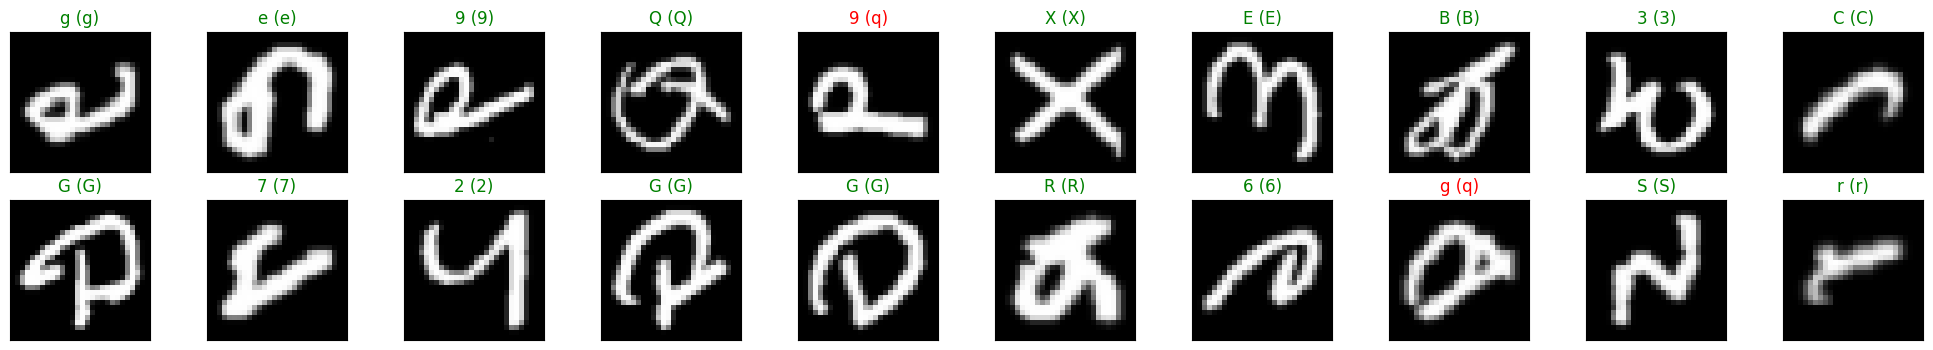

In [48]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# move model to GPU if CUDA is available
if train_on_gpu:
    model = model.cuda()

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.__next__()

# move images and labels to GPU if CUDA is available
if train_on_gpu:
    images, labels = images.cuda(), labels.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# move images and preds back to CPU for displaying images and numpy operations
if train_on_gpu:
    images, preds = images.cpu(), preds.cpu()

# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(label_dict.get(preds[idx].item())), str(label_dict.get(labels[idx].item()))),
                 color=("green" if preds[idx]==labels[idx] else "red"))